### Makes plan view and sections plot of ROMS output 
This script was originally written by Dylan Schlichting and has been edited/adapted.

In [70]:
#Packages 
import numpy as np
import cartopy
import glob
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings
import xarray as xr
import os
import xroms
from glob import glob
warnings.filterwarnings("ignore") #turns off annoying warnings

In [71]:
# === Paths ===
grd_file = '/global/homes/b/bundzis/Projects/Beaufort_ROMS_idealized_jet/Include/grd_500m_002.nc'
# ini_file = '/global/homes/b/bundzis/Projects/Beaufort_ROMS_idealized_jet/Include/ini_ice_1km_002.nc'
# his_file = '/pscratch/sd/d/dylan617/beaufort_roms/runs_idealized/outputs/roms_his*.nc'
his_file = '/pscratch/sd/b/bundzis/Beaufort_ROMS_idealized_jet_scratch/roms_his_ice_wind_w_dvd_tair_pair_long_short_dx_500m_*.nc'

# === Load datasets ===
dsg = xr.open_dataset(grd_file)
# ds = xr.open_mfdataset(his_file)
ds = xroms.open_mfnetcdf(glob(his_file))
ds, grid = xroms.roms_dataset(ds)

In [72]:
def to_rho(var):
    if var.dims[-1] != 'xi_rho':
        var = grid.interp(var, 'X', to='center', boundary='extend')
    if var.dims[-2] != 'eta_rho':
        var = grid.interp(var, 'Y', to='center', boundary='extend')
    return var

def velgrad(ds,grid):
    '''
    Calculates flow invariants vorticity, divergence, strain
    '''
    us = ds.u 
    vs = ds.v

    dudx = grid.derivative(us, 'X', boundary='extend')
    dvdy = grid.derivative(vs, 'Y', boundary='extend')
    dudy = to_rho(grid.derivative(us, 'Y', boundary='extend'))
    dvdx = to_rho(grid.derivative(vs, 'X', boundary='extend'))
    # Vorticity:  v_x - u_y
    rv = (dvdx - dudy)/ds.f
    rv.name = 'Normalized vorticity'

    # Divergence: u_x + v_y
    delta = (dudx + dvdy)/ds.f
    delta.name = 'Normalized divergence'

    # Major axis of deformation
    alpha = ( np.sqrt( (dudx-dvdy)**2 + (dvdx+dudy)**2 ) )/ds.f
    alpha.name = 'Normalized strain'
    
    return rv,delta,alpha

rv,delta,alpha = velgrad(ds,grid)

In [73]:
# Convert to km
xrho = dsg.x_rho / 1000
xu = dsg.x_u / 1000
yrho = dsg.y_rho / 1000 
yu = dsg.y_u / 1000
print(ds.ocean_time[-1].values)

0001-01-07 06:00:00


<a list of 6 text.Text objects>

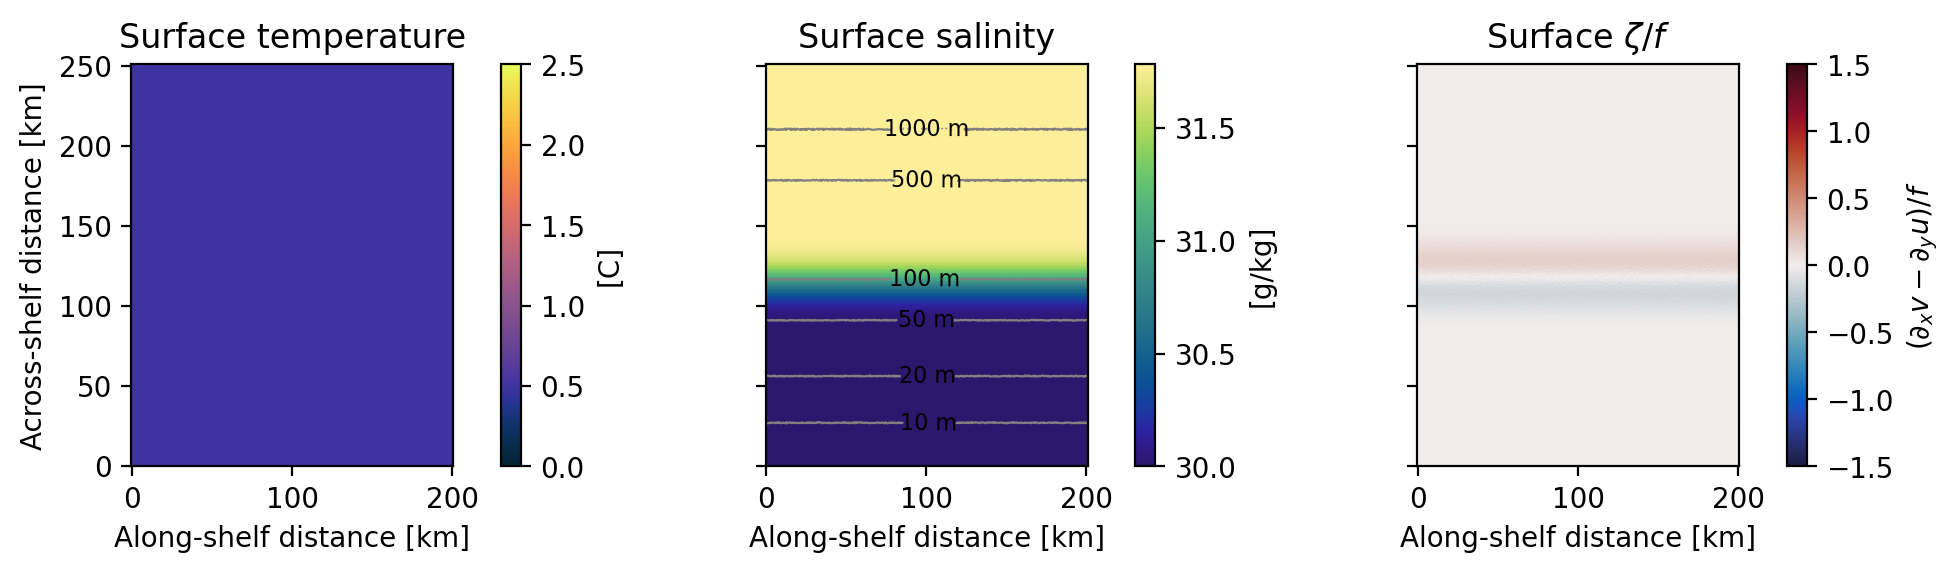

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(9.75, 2.75),
                       constrained_layout=True, 
                       sharex=True, sharey=True, dpi=200)

temp = ds.temp[0,-1]
salt = ds.salt[0,-1]
zeta = rv[0,-1]

# Temperature
m = ax[0].pcolormesh(xrho, yrho, temp, cmap=cmo.thermal, vmin = 0, vmax = 2.5)
fig.colorbar(m, ax=ax[0], label='[C]')

# Salinity
m1 = ax[1].pcolormesh(xrho, yrho, salt, cmap=cmo.haline)
fig.colorbar(m1, ax=ax[1], label='[g/kg]')

# U-velocity
m2 = ax[2].pcolormesh(xrho, yrho, zeta, cmap=cmo.balance,
                      vmin = -1.5, vmax = 1.5)
fig.colorbar(m2, ax=ax[2], label='$(\partial_x v - \partial_y u)/f$')

# Set consistent axis limits
for a in ax:
    # a.set_xlim(x_min, x_max)
    # a.set_ylim(y_min, y_max)
    a.set_xlabel('Along-shelf distance [km]')
    a.set_aspect(1.0)

ax[0].set_ylabel('Across-shelf distance [km]')
ax[0].set_title('Surface temperature')
ax[1].set_title('Surface salinity')
ax[2].set_title(r'Surface $\zeta/f$')

# Contours for bathymetry
positions = [(100, 10),(100,60),(100,90),(100,140),(100,160),(100,210)]
cs = ax[1].contour(xrho, yrho, ds.h, levels=[10, 20, 50, 100, 500, 1000],
                   colors='grey', linewidths=0.8)
ax[1].clabel(cs, fmt='%d m', manual=positions, inline=True, fontsize=8, colors='black')


Text(0.5, 1.0, 'Surface $\\zeta/f$')

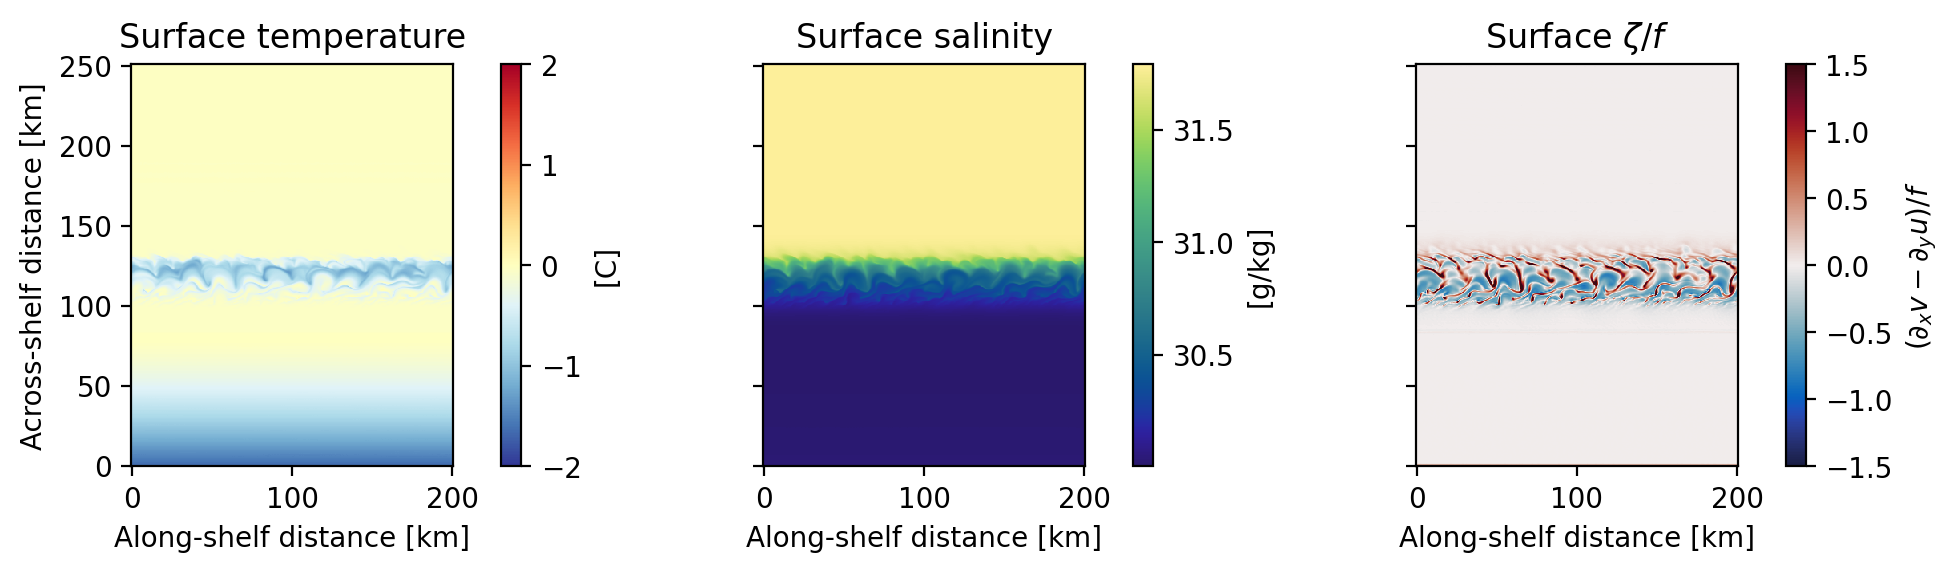

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(9.75, 2.75),
                       constrained_layout=True, 
                       sharex=True, sharey=True, dpi=200)

temp = ds.temp[-1,-1]
salt = ds.salt[-1,-1]
zeta = rv[-1,-1]

# Temperature
m = ax[0].pcolormesh(xrho, yrho, temp, cmap='RdYlBu_r', vmin = -2, vmax = 2)
fig.colorbar(m, ax=ax[0], label='[C]')

# Salinity
m1 = ax[1].pcolormesh(xrho, yrho, salt, cmap=cmo.haline)
fig.colorbar(m1, ax=ax[1], label='[g/kg]')

# U-velocity
m2 = ax[2].pcolormesh(xrho, yrho, zeta, cmap=cmo.balance,
                      vmin = -1.5, vmax = 1.5)
fig.colorbar(m2, ax=ax[2], label='$(\partial_x v - \partial_y u)/f$')

# Set consistent axis limits
for a in ax:
    # a.set_xlim(x_min, x_max)
    # a.set_ylim(y_min, y_max)
    a.set_xlabel('Along-shelf distance [km]')
    a.set_aspect(1.0)

ax[0].set_ylabel('Across-shelf distance [km]')
ax[0].set_title('Surface temperature')
ax[1].set_title('Surface salinity')
ax[2].set_title(r'Surface $\zeta/f$')

# Contours for bathymetry
# positions = [(100, 10),(100,60),(100,90),(100,140),(100,160),(100,210)]
# cs = ax[1].contour(xrho, yrho, ds.h, levels=[10, 20, 50, 100, 500, 1000],
#                    colors='grey', linewidths=0.8)
# ax[1].clabel(cs, fmt='%d m', manual=positions, inline=True, fontsize=8, colors='black')


Text(0.5, 1.0, 'Ice concentration')

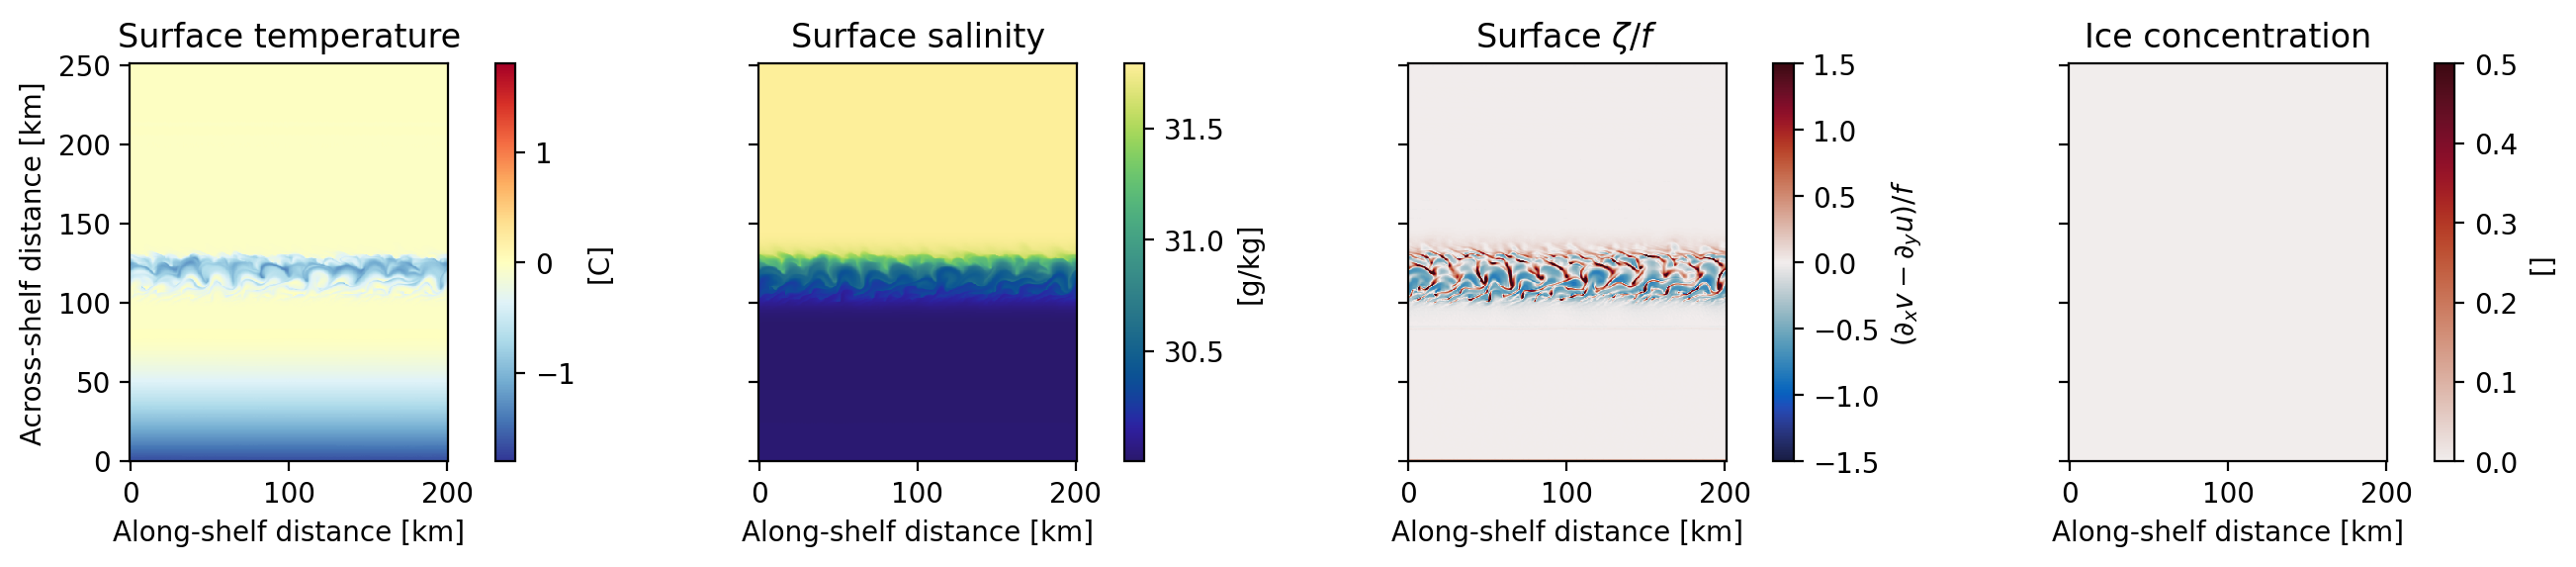

In [76]:
fig, ax = plt.subplots(1, 4, figsize=((9.75/3)*4, 2.75),
                       constrained_layout=True, 
                       sharex=True, sharey=True, dpi=200)

temp = ds.temp[-1,-1]
salt = ds.salt[-1,-1]
zeta = rv[-1,-1]
aice = ds.Aice[-1]
hice = ds.ice_thickness[-1]

# Temperature
m = ax[0].pcolormesh(xrho, yrho, temp, cmap='RdYlBu_r', vmin = -1.8, vmax = 1.8)
fig.colorbar(m, ax=ax[0], label='[C]')

# Salinity
m1 = ax[1].pcolormesh(xrho, yrho, salt, cmap=cmo.haline)
fig.colorbar(m1, ax=ax[1], label='[g/kg]')

# U-velocity
m2 = ax[2].pcolormesh(xrho, yrho, zeta, cmap=cmo.balance,
                      vmin = -1.5, vmax = 1.5)
fig.colorbar(m2, ax=ax[2], label='$(\partial_x v - \partial_y u)/f$')

# U-velocity
m3 = ax[3].pcolormesh(xrho, yrho, aice, cmap=cmo.amp,
                      vmin = 0, vmax = 0.5)
fig.colorbar(m3, ax=ax[3], label='[]')

# Set consistent axis limits
for a in ax:
    # a.set_xlim(x_min, x_max)
    # a.set_ylim(y_min, y_max)
    a.set_xlabel('Along-shelf distance [km]')
    a.set_aspect(1.0)

ax[0].set_ylabel('Across-shelf distance [km]')
ax[0].set_title('Surface temperature')
ax[1].set_title('Surface salinity')
ax[2].set_title(r'Surface $\zeta/f$')
ax[3].set_title(r'Ice concentration')


<function matplotlib.pyplot.show(close=None, block=None)>

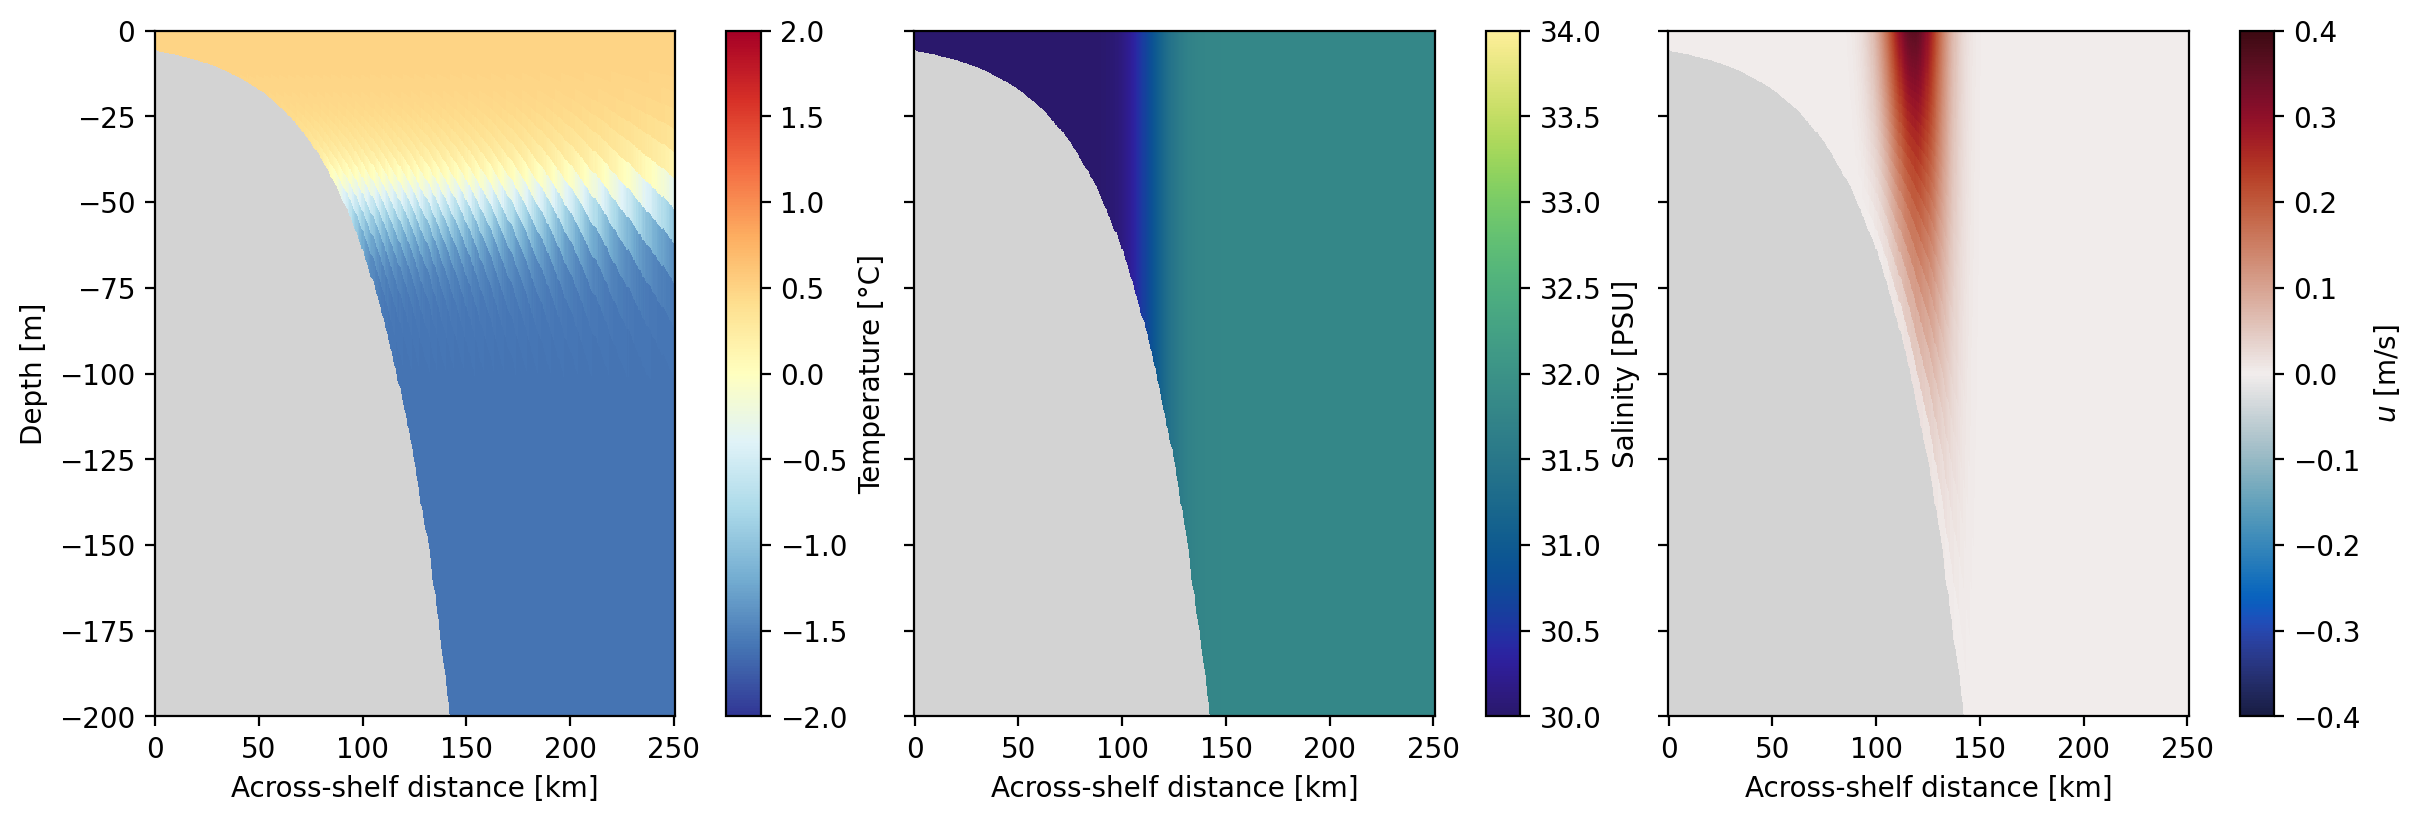

In [77]:
tidx = 0

# Pick a fixed along-shelf location
xi_idx = 100  # pick a reasonable index along xi_rho

# --- Extract Data at the Final Time Step ---
temp_section = ds.temp[tidx, :, :, xi_idx]        # shape: (s_rho, eta_rho)
salt_section = ds.salt[tidx, :, :, xi_idx]        # shape: (s_rho, eta_rho)
z_rho_section = ds.z_rho[tidx, :, :, xi_idx]       # shape: (s_rho, eta_rho)
u_section = ds.u[tidx, :, :, xi_idx]  # shape: (s_rho, eta_u or eta_rho)

# --- Plotting 3x1 Subplots ---

# 1. Create the figure and a 3x1 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, 
                         sharey=True, dpi = 200, constrained_layout=True)

# 2. Define the horizontal coordinate (assuming it's y_rho for the across-shelf direction)
# Use dsg.y_rho for the coordinate.
y_coord = dsg.y_rho[:, 0] / 1000  # Across-shelf distance in km

# Define common plotting parameters
common_ylim = (-200, 0)
xlabel = 'Across Shelf Distance [km]'

# --- Plot 1: Temperature ---
ax = axes[0]
pcm_temp = ax.pcolormesh(y_coord, z_rho_section, temp_section,
                         cmap='RdYlBu_r', vmin=-2, vmax=2)
fig.colorbar(pcm_temp, ax=ax, label='Temperature [°C]')
# ax.set_title(f'Vertical Section at $\\xi={xi_idx}$')
ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)

# --- Plot 2: Salinity ---
ax = axes[1]
# You'll need appropriate vmin/vmax for salinity based on your data.
# Using typical values for demonstration:
pcm_salt = ax.pcolormesh(y_coord, z_rho_section, salt_section,
                         cmap=cmo.haline, vmin=30, vmax=34)
fig.colorbar(pcm_salt, ax=ax, label='Salinity [PSU]')
# ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)

# --- Plot 3: U-Velocity ---
ax = axes[2]
# U-velocity is cross-shelf/along-shelf. Use vmin/vmax for flow speed.
# Assuming u is the along-shelf velocity and 0 is the interface:
pcm_u = ax.pcolormesh(y_coord, z_rho_section, u_section,
                      cmap=cmo.balance, vmin=-0.4, vmax=0.4) # Example range
fig.colorbar(pcm_u, ax=ax, label='$u$ [m/s]')
# ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)
ax.set_xlabel(xlabel) # Only set x-label on the bottom plot (shared x-axis)

for i in range(3):
    axes[i].set_facecolor('lightgray')
    axes[i].set_xlabel('Across-shelf distance [km]')

# Adjust layout to prevent overlap
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

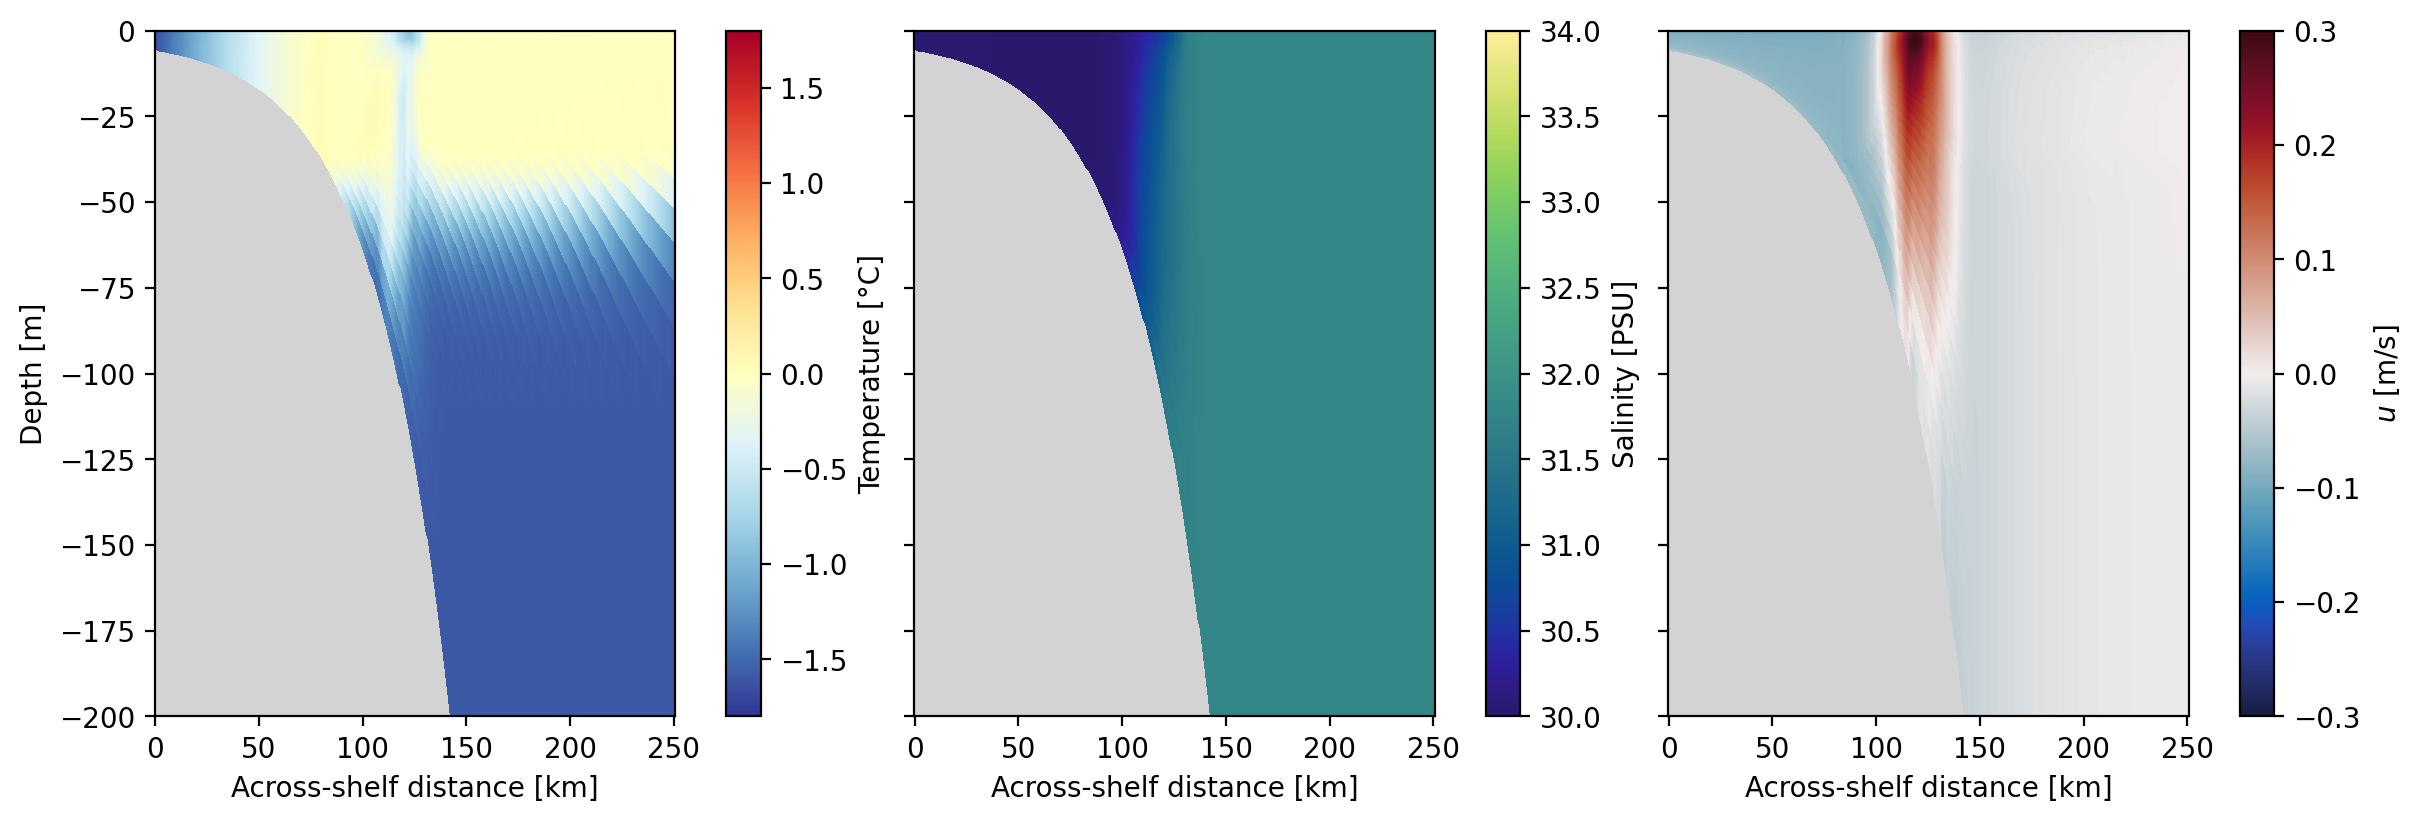

In [78]:
tidx = -1

# --- Extract Data at the Final Time Step ---
temp_section = ds.temp[tidx, :, :].mean('xi_rho')        # shape: (s_rho, eta_rho)
salt_section = ds.salt[tidx, :, :].mean('xi_rho')        # shape: (s_rho, eta_rho)
z_rho_section = ds.z_rho[tidx, :, :].mean('xi_rho')       # shape: (s_rho, eta_rho)
u_section = ds.u[tidx, :, :].mean('xi_u')  # shape: (s_rho, eta_u or eta_rho)

# --- Plotting 3x1 Subplots ---

# 1. Create the figure and a 3x1 grid of axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharex=True, 
                         sharey=True, dpi = 200, constrained_layout=True)

# 2. Define the horizontal coordinate (assuming it's y_rho for the across-shelf direction)
# Use dsg.y_rho for the coordinate.
y_coord = dsg.y_rho[:, 0] / 1000  # Across-shelf distance in km

# Define common plotting parameters
common_ylim = (-200, 0)
xlabel = 'Across Shelf Distance [km]'

# --- Plot 1: Temperature ---
ax = axes[0]
pcm_temp = ax.pcolormesh(y_coord, z_rho_section, temp_section,
                         cmap='RdYlBu_r', vmin=-1.8, vmax=1.8)
fig.colorbar(pcm_temp, ax=ax, label='Temperature [°C]')
# ax.set_title(f'Vertical Section at $\\xi={xi_idx}$')
ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)

# --- Plot 2: Salinity ---
ax = axes[1]
# You'll need appropriate vmin/vmax for salinity based on your data.
# Using typical values for demonstration:
pcm_salt = ax.pcolormesh(y_coord, z_rho_section, salt_section,
                         cmap=cmo.haline, vmin=30, vmax=34)
fig.colorbar(pcm_salt, ax=ax, label='Salinity [PSU]')
# ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)

# --- Plot 3: U-Velocity ---
ax = axes[2]
# U-velocity is cross-shelf/along-shelf. Use vmin/vmax for flow speed.
# Assuming u is the along-shelf velocity and 0 is the interface:
pcm_u = ax.pcolormesh(y_coord, z_rho_section, u_section,
                      cmap=cmo.balance, vmin=-0.3, vmax=0.3) # Example range
fig.colorbar(pcm_u, ax=ax, label='$u$ [m/s]')
# ax.set_ylabel('Depth [m]')
ax.set_ylim(common_ylim)
ax.set_xlabel(xlabel) # Only set x-label on the bottom plot (shared x-axis)

for i in range(3):
    axes[i].set_facecolor('lightgray')
    axes[i].set_xlabel('Across-shelf distance [km]')

# Adjust layout to prevent overlap
plt.show